<a href="https://colab.research.google.com/github/mariachurches/TFM/blob/main/segmentation/DeepLabv3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Montamos google drive para tener acceso a las imagenes
2. 

In [1]:
#Imports
import os
import csv
import cv2
import PIL
import torch
import random
import torchvision
import numpy as np
from PIL import Image
from tqdm import tqdm
from torch import nn, optim
from statistics import mean
import matplotlib.pyplot as plt
from torch.nn import functional as F
from torchvision import transforms as T
from google.colab.patches import cv2_imshow
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.transforms.functional import InterpolationMode

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
if not os.path.exists('/content/Escoliosis/labels_files'):
  !unzip /content/drive/MyDrive/TFM/Escoliosis.zip -d . &> /dev/null

In [4]:
#Creamos variables que contengan los directorios a utilizar
IMAGES_PATH = "/content/Escoliosis/orig_img"
MASKS_PATH = "/content/Escoliosis/segm_img"
LABELS_PATH     = "/content/Escoliosis/labels_files"
OUTPUT_IMAGES_PATH     = "/content/drive/MyDrive/TFM/results/"
OUTPUT_MODEL_PATH     = "/content/drive/MyDrive/TFM/models"

In [5]:
labels_files   = os.listdir(LABELS_PATH)
images_dataset = os.listdir(IMAGES_PATH)

In [6]:
images_dataset = [x for x in images_dataset if "jpg" in x]
print(f"Hay un total de {len(images_dataset)} imagenes ")

Hay un total de 609 imagenes 


In [7]:
angles = []
for cvs_l in labels_files:
  with open(os.path.join(LABELS_PATH, cvs_l), newline='') as File:  
      reader = csv.reader(File)
      for row in reader:
          angles.append(row)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(images_dataset, angles, test_size=0.1, shuffle = True, random_state = 8)
X_train, X_val, y_train, y_val   = train_test_split(X_train, y_train, test_size=0.22, random_state= 8)

In [9]:
shapes = [cv2.imread(os.path.join(IMAGES_PATH,x),0).shape for x in images_dataset]
K=0
height =  (int(mean([val[K] for val in shapes])) // 8) * 8
K=1
width = (int(mean(val[K] for val in shapes)) // 8) * 8

height=800
width=500

In [10]:
class my_own_transformation(object):

    def __call__(self, img):
        ret, bw_img = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)
        return bw_img

    def __repr__(self):
        return "custom transformation for masks"

class __img_to_tensor(object):

    def __call__(self, img):
        img = np.asarray(img)
        img = img.astype(np.float32) / 255.0
        img = torch.from_numpy(img)
        return img

    def __repr__(self):
        return "custom transformation for masks"

class my_normalize(object):
    '''Normalize image'''
 
    def __call__(self, img):
        return img.type(torch.FloatTensor)/255

In [11]:
transforms_img   = T.Compose([T.ToPILImage(), T.Resize((height,width), interpolation=InterpolationMode.NEAREST), T.ToTensor(), T.Lambda(my_normalize())])
transforms_masks = T.Compose([T.Lambda(my_own_transformation()), T.ToPILImage(), T.Resize((height,width), interpolation=InterpolationMode.NEAREST), T.Lambda(__img_to_tensor()), T.Lambda(my_normalize())])

In [12]:
BATCH_SIZE = 2
TRAIN_SIZE = int(len(images_dataset)*0.7)
VAL_SIZE = int(len(images_dataset) * 0.2)
TEST_SIZE = len(images_dataset) - TRAIN_SIZE - VAL_SIZE
print(TRAIN_SIZE, VAL_SIZE, TEST_SIZE)

426 121 62


In [13]:
from pathlib import Path
from typing import Any, Callable, Optional

import numpy as np
from PIL import Image
from torchvision.datasets.vision import VisionDataset


class SegmentationDataset(VisionDataset):
    """A PyTorch dataset for image segmentation task.
    The dataset is compatible with torchvision transforms.
    The transforms passed would be applied to both the Images and Masks.
    """
    def __init__(self,
                 image_folder: str,
                 mask_folder: str,
                 transforms: Optional[Callable] = None,
                 seed: int = None,
                 fraction: float = None,
                 subset: str = None,
                 image_color_mode: str = "rgb",
                 mask_color_mode: str = "grayscale") -> None:

        image_folder_path = image_folder
        mask_folder_path = mask_folder

        self.image_color_mode = image_color_mode
        self.mask_color_mode = mask_color_mode

        self.fraction = fraction
        self.image_list = np.array(sorted(image_folder_path.glob("*")))
        self.mask_list = np.array(sorted(mask_folder_path.glob("*")))
        if seed:
            np.random.seed(seed)
            indices = np.arange(len(self.image_list))
            np.random.shuffle(indices)
            self.image_list = self.image_list[indices]
            self.mask_list = self.mask_list[indices]
        if subset == "Train":
            self.image_names = self.image_list[:int(
                    np.ceil(len(self.image_list) * (1 - self.fraction)))]
            self.mask_names = self.mask_list[:int(
                    np.ceil(len(self.mask_list) * (1 - self.fraction)))]
        else:
            self.image_names = self.image_list[
                    int(np.ceil(len(self.image_list) * (1 - self.fraction))):]
            self.mask_names = self.mask_list[
                    int(np.ceil(len(self.mask_list) * (1 - self.fraction))):]

    def __len__(self) -> int:
        return len(self.image_names)

    def __getitem__(self, index: int) -> Any:
        image_path = self.image_names[index]
        mask_path = self.mask_names[index]
        with open(image_path, "rb") as image_file, open(mask_path,
                                                        "rb") as mask_file:
            image = Image.open(image_file)
            if self.image_color_mode == "rgb":
                image = image.convert("RGB")
            elif self.image_color_mode == "grayscale":
                image = image.convert("L")
            mask = Image.open(mask_file)
            if self.mask_color_mode == "rgb":
                mask = mask.convert("RGB")
            elif self.mask_color_mode == "grayscale":
                mask = mask.convert("L")
            sample = {"image": image, "mask": mask}
            if self.transforms:
                sample["image"] = self.transforms(sample["image"])
                sample["mask"] = self.transforms(sample["mask"])
            return sample

In [14]:
""" DeepLabv3 Model download and change the head for your prediction"""
from torchvision.models.segmentation.deeplabv3 import DeepLabHead
from torchvision import models


def createDeepLabv3(outputchannels=1):
    """DeepLabv3 class with custom head
    Args:
        outputchannels (int, optional): The number of output channels
        in your dataset masks. Defaults to 1.
    Returns:
        model: Returns the DeepLabv3 model with the ResNet101 backbone.
    """
    # model = models.segmentation.deeplabv3_resnet101(pretrained=True,
                                                    # progress=True)
    model = models.segmentation.deeplabv3_resnet50(pretrained=True,
                                                    progress=True)
    model.classifier = DeepLabHead(2048, outputchannels)
    # Set the model in training mode
    model.train()
    return model

In [15]:
import sys
sys.path.append('/content/drive/MyDrive/TFM/My_modules/')
from Nets2 import UNet
from Datasets import Spine_Dataset_Segmentation
import Nets
from Utils import Utils as utils

In [18]:
class NetManager:
    def __init__(self):
        self.model = createDeepLabv3()
        self.model.train()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=0.0001, betas=(0.9, 0.999), weight_decay=0)
        self.criterion = torch.nn.CrossEntropyLoss()
        self.device = torch.device("cpu")
        if torch.cuda.is_available():
            self.device = torch.device("cuda:0")
        self.model.to(self.device)
        self.print_every = 50

    def load(self, filename):
        if os.path.isfile(filename):
            print("=> loading checkpoint '{}'".format(filename))
            checkpoint = torch.load(filename, map_location=self.device)
            self.model.load_state_dict(checkpoint['state_dict'])
            self.optimizer.load_state_dict(checkpoint['optimizer'])
            print("=> loaded checkpoint '{}'".format(filename))
        else:
            print("=> no checkpoint found at '{}'".format(filename))

    def save(self, filename):
        state = {'state_dict': self.model.state_dict(), 'optimizer': self.optimizer.state_dict()}
        torch.save(state, filename)

    def set_device(self, device):
        if torch.cuda.is_available():
            self.device = torch.device(device)
        self.model.to(self.device)

    def train(self, data_train, data_valid, images_path, masks_path, transforms_img, transforms_masks, output_path, max_epoch, batch_size):
        train_dataset = Spine_Dataset_Segmentation(data_train, images_path, masks_path, transforms_img, transforms_masks, output_path)
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=False, drop_last=True)

        valid_dataset = Spine_Dataset_Segmentation(data_valid, images_path, masks_path, transforms_img, transforms_masks, output_path)
        valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=False,drop_last=True)

        train_best_loss = 1.0e99 # self.__validate(train_loader)
        valid_best_loss = self.__validate(valid_loader)
        for epoch in range(max_epoch):
            train_loss = self.__train_epoch(train_loader)
            if train_loss < train_best_loss:
                train_best_loss = train_loss
                self.save(os.path.join(OUTPUT_MODEL_PATH,'deeplabv3_training.pt'))
                print('Epoch {}: New best training loss: {}'.format(epoch, train_best_loss))
            else:
                print('Epoch {}: Current training loss: {}. Best loss: {}'.format(epoch, train_loss, train_best_loss))

            valid_loss = self.__validate(valid_loader)
            if valid_loss < valid_best_loss:
                valid_best_loss = valid_loss
                self.save(os.path.join(OUTPUT_MODEL_PATH,'deeplabv3_validation.pt'))
                print('Epoch {}: New best validation loss: {}'.format(epoch, valid_best_loss))
            else:
                print('Epoch {}: Current validation loss: {}. Best loss: {}'.format(epoch, valid_loss, valid_best_loss))

    def __train_epoch(self, train_loader):
        self.model.train()
        torch.enable_grad()
        train_loss = 0
        count = len(train_loader)
        for i, (batch, label) in enumerate(tqdm(train_loader)):
            self.optimizer.zero_grad()
            output = self.model(batch.to(self.device))
            loss = self.criterion(output['out'].squeeze(1), label.to(self.device))
            train_loss += loss.item()

            loss.backward()
            self.optimizer.step()

            if (i + 1) % self.print_every == 0:
                tqdm.write('Sample {}/{}. Current training loss: {} '.format(i + 1, count, train_loss / i))
        print()
        train_loss /= count
        return train_loss

    def __validate(self, valid_loader):
        self.model.eval()
        torch.no_grad()
        eval_loss = 0
        count = len(valid_loader)
        for i, (batch, label) in enumerate(tqdm(valid_loader)):
            output = self.model(batch.to(self.device))
            loss = self.criterion(output['out'].squeeze(1), label.to(self.device))
            eval_loss += loss.item()

            if (i + 1) % self.print_every == 0:
                tqdm.write('Sample {}/{}. Current validation loss: {}'.format(i + 1, count, eval_loss / i))
        print()
        eval_loss /= count
        return eval_loss

    def test(self, data_test, images_path, masks_path, transforms_img, transforms_masks, output_path):
        utils.remove_images_from_path(output_path)
        test_dataset = Spine_Dataset_Segmentation(data_test, images_path, masks_path, transforms_img, transforms_masks, output_path)
        test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0, pin_memory=False)

        self.model.eval()
        torch.no_grad()
        count = len(test_loader)
        for i, (batch, _) in enumerate(tqdm(test_loader)):
            output = self.model(batch.to(self.device))

            with torch.no_grad():
             if torch.cuda.is_available():
              a = self.model(batch.to(self.device).type(torch.cuda.FloatTensor)/255)
             else:
              a = self.model(batch.to(device).type(torch.FloatTensor)/255)
            outImage = a['out'].cpu().detach().numpy()[0]
            cv2_imshow(outImage.transpose(1,2,0))

            test_dataset.save_output(a, \
                    os.path.join(output_path, test_dataset.get_filename(i)))

            if (i + 1) % self.print_every == 0:
                tqdm.write('Sample {}/{}'.format(i + 1, count))

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


=> loading checkpoint '/content/drive/MyDrive/TFM/models/deeplabv3_training.pt'
=> loaded checkpoint '/content/drive/MyDrive/TFM/models/deeplabv3_training.pt'


  0%|          | 0/61 [00:00<?, ?it/s]

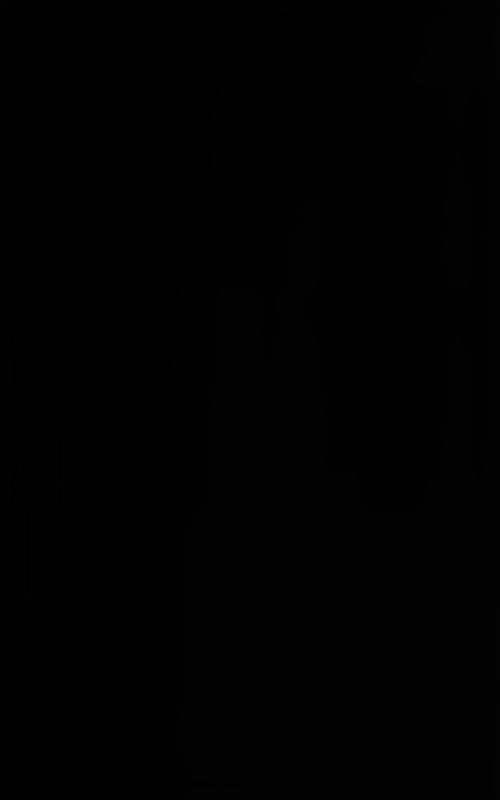

  0%|          | 0/61 [00:00<?, ?it/s]


ValueError: ignored

In [19]:
net = NetManager()
if False:
  net.load("files_name")
max_epoch=10

# Train=True
Train = False
if Train:
  #net.load(os.path.join(OUTPUT_MODEL_PATH, "deeplabv3_training.pt"))
  net.train(X_train, X_val, IMAGES_PATH, MASKS_PATH, transforms_img, transforms_masks, OUTPUT_IMAGES_PATH, max_epoch, BATCH_SIZE)

else:
  net.load(os.path.join(OUTPUT_MODEL_PATH, "deeplabv3_training.pt"))
  net.test(X_test, IMAGES_PATH, MASKS_PATH, transforms_img, transforms_masks, OUTPUT_IMAGES_PATH)
  

In [ ]:
import torch
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import time

model_path = os.path.join(OUTPUT_MODEL_PATH, "deeplabv3_training.pt")
image_path = IMAGES_PATH

# Load the trained model
if torch.cuda.is_available():
    model = torch.load(model_path)
else:
    model = torch.load(model_path, map_location=torch.device('cpu'))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

checkpoint = torch.load(model_path, map_location=device)
model.load_state_dict(checkpoint['state_dict'])
optimizer.load_state_dict(checkpoint['optimizer'])
    
print(device)
# Set the model to evaluate mode
model.eval()

# Read  a sample image and mask from the data-set
for i in X_test:
  originalImage = cv2.imread(os.path.join(image_path,i))

  # Resize image
  img = cv2.resize(originalImage, (800, 500), cv2.INTER_AREA).transpose(2,0,1)

  img = img.reshape(1, 3, img.shape[1],img.shape[2])

  start_time = time.time()
  with torch.no_grad():
      if torch.cuda.is_available():
        a = model(torch.from_numpy(img).to(device).type(torch.cuda.FloatTensor)/255)
      else:
          a = model(torch.from_numpy(img).to(device).type(torch.FloatTensor)/255)
  print("--- %s seconds ---" % (time.time() - start_time))

  outImage = a['out'].cpu().detach().numpy()[0]
  plt.imshow(outImage.transpose(1,2,0))
  break